# Панкратов Виктор, задание 7
## Визуализировать забывание выборки моделью: 
1)Обучить модель на бинарной классификации MNIST с классами 0, 1

2)Дообучить модель на новых цифрах (2 -> класс "0", 3-> класс "1")

3)Визуализировать качество классификации цифр 0 и 1 в зависимости от итерации дообучения.

In [1]:
import torch
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm 
import torch.utils.data


In [2]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()



11501568/11490434 [==============================] - 0s 0us/step


In [3]:
X_two,y_two = train_X[train_y<2],  train_y[train_y<2]
X_two_test,y_two_test = test_X[test_y<2],  test_y[test_y<2]
X_four,y_four = train_X[train_y<4],  train_y[train_y<4]%2
X_four_test,y_four_test = test_X[test_y<4], test_y[test_y<4]%2
X_three_four,y_three_four = train_X[np.logical_and(train_y<4,train_y>1)], train_y[np.logical_and(train_y<4,train_y>1)]%2
X_three_four_test,y_three_four_test = test_X[np.logical_and(test_y<4,test_y>1)], test_y[np.logical_and(test_y<4,test_y>1)]%2

In [4]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(
  list(zip(X_two,y_two)),batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
  list(zip(X_two_test,y_two_test)),batch_size=batch_size, shuffle=True)
train_loader4 = torch.utils.data.DataLoader(
  list(zip(X_four,y_four)),batch_size=batch_size, shuffle=True)
test_loader4 = torch.utils.data.DataLoader(
  list(zip(X_four_test,y_four_test)),batch_size=batch_size, shuffle=True)
train_loader34 = torch.utils.data.DataLoader(
  list(zip(X_three_four,y_three_four)),batch_size=batch_size, shuffle=True)
test_loader34 = torch.utils.data.DataLoader(
  list(zip(X_three_four_test,y_three_four_test)),batch_size=batch_size, shuffle=True)


In [5]:

class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        self.fc0 = nn.Linear(28*28,320)
        self.t1 = nn.Tanh() 
        self.fc1 = nn.Linear(320,80) 
        self.t2 = nn.Tanh()  
        self.fc2 = nn.Linear(80,40)
        self.t3 = nn.Tanh() 
        self.fc3 = nn.Linear(40,2)
    def forward(self, x):
        x = x.view(-1,28*28).float()
        x = self.fc0(x)
        x = self.t1(x)
        x = self.fc1(x)
        x = self.t2(x)
        x = self.fc2(x)
        x = self.t3(x)
        x = self.fc3(x)
        return F.log_softmax(x,dim = 0)

In [6]:
def train(net,optimiser,n_epochs):
  for epoch in trange(n_epochs):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      optimiser.zero_grad()
      output = net(data)
      loss = F.nll_loss(output, target)
      loss.backward()
      optimiser.step()
    net.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
      for batch_idx, (data, target) in enumerate(test_loader):
        output = net(data)
        test_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    print('Epoch {}, Accuracy {}'.format(epoch, 100. * correct / len(test_loader.dataset)))
  return net, 100. * correct / len(test_loader.dataset)
def forget(net,optimiser,n_epochs,loader_train,loader_test):
  ans = []
  for epoch in trange(n_epochs):
    net.train()
    for batch_idx, (data, target) in enumerate(loader_train):
      optimiser.zero_grad()
      output = net(data)
      loss = F.nll_loss(output, target)
      loss.backward()
      optimiser.step()
    net.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
      for batch_idx, (data, target) in enumerate(loader_test):
        output = net(data)
        test_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    print('Epoch {}, Accuracy {}'.format(epoch, 100. * correct / len(loader_test.dataset)))
    ans.append(100. * correct / len(loader_test.dataset))
  return ans

In [ ]:
net = MnistNet() #Запустил второй раз по ошибке, поэтому выходные данные у этой ячейки отсутствуют
optimiser = torch.optim.Adam(net.parameters())
answers = []
for i in range(10):
  net1, acc = train(net,optimiser,2)
  ans = forget(net1,optimiser,20,train_loader4,test_loader)
  answers.append(ans)

<function matplotlib.pyplot.show>

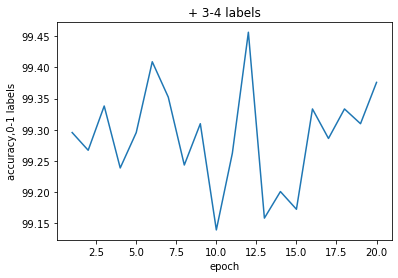

In [ ]:
ans = np.zeros(20)
for i in range(10):
  ans = ans + np.array(answers[i])/10
x = np.arange(1,21,1)
plt.plot(x,ans)
plt.title('+ 3-4 labels')
plt.xlabel('epoch')
plt.ylabel('accuracy,0-1 labels')
plt.show

In [8]:
net = MnistNet()
optimiser = torch.optim.Adam(net.parameters())
answers = []
for i in range(10):
  net1, acc = train(net,optimiser,2)
  ans = forget(net1,optimiser,20,train_loader34,test_loader)
  answers.append(ans)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.62174987792969
Epoch 1, Accuracy 99.76359558105469


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 52.2458610534668
Epoch 1, Accuracy 71.7730484008789
Epoch 2, Accuracy 71.86761474609375
Epoch 3, Accuracy 65.67375946044922
Epoch 4, Accuracy 53.71158218383789
Epoch 5, Accuracy 61.70212936401367
Epoch 6, Accuracy 74.75177001953125
Epoch 7, Accuracy 70.82742309570312
Epoch 8, Accuracy 64.58628845214844
Epoch 9, Accuracy 64.58628845214844
Epoch 10, Accuracy 73.71158599853516
Epoch 11, Accuracy 77.16312408447266
Epoch 12, Accuracy 79.05437469482422
Epoch 13, Accuracy 72.00945281982422
Epoch 14, Accuracy 73.00236511230469
Epoch 15, Accuracy 72.76596069335938
Epoch 16, Accuracy 82.55319213867188
Epoch 17, Accuracy 75.88652801513672
Epoch 18, Accuracy 78.48699951171875
Epoch 19, Accuracy 77.63593292236328


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.66902923583984
Epoch 1, Accuracy 99.95272064208984


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 80.04727935791016
Epoch 1, Accuracy 84.53900909423828
Epoch 2, Accuracy 83.54609680175781
Epoch 3, Accuracy 72.76596069335938
Epoch 4, Accuracy 71.2529525756836
Epoch 5, Accuracy 71.48936462402344
Epoch 6, Accuracy 73.71158599853516
Epoch 7, Accuracy 66.95035552978516
Epoch 8, Accuracy 78.34515380859375
Epoch 9, Accuracy 74.32624053955078
Epoch 10, Accuracy 64.30259704589844
Epoch 11, Accuracy 69.31442260742188
Epoch 12, Accuracy 67.42316436767578
Epoch 13, Accuracy 68.2269515991211
Epoch 14, Accuracy 70.63829803466797
Epoch 15, Accuracy 74.32624053955078
Epoch 16, Accuracy 75.60283660888672
Epoch 17, Accuracy 67.51773071289062
Epoch 18, Accuracy 74.5626449584961
Epoch 19, Accuracy 69.36170196533203


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.76359558105469
Epoch 1, Accuracy 99.858154296875


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 71.96217346191406
Epoch 1, Accuracy 76.87943267822266
Epoch 2, Accuracy 70.02364349365234
Epoch 3, Accuracy 67.9432601928711
Epoch 4, Accuracy 71.2529525756836
Epoch 5, Accuracy 69.64539337158203
Epoch 6, Accuracy 72.76596069335938
Epoch 7, Accuracy 73.75886535644531
Epoch 8, Accuracy 71.34751892089844
Epoch 9, Accuracy 67.99054718017578
Epoch 10, Accuracy 76.78486633300781
Epoch 11, Accuracy 69.69267272949219
Epoch 12, Accuracy 75.2245864868164
Epoch 13, Accuracy 67.65957641601562
Epoch 14, Accuracy 75.98108673095703
Epoch 15, Accuracy 77.63593292236328
Epoch 16, Accuracy 64.72813415527344
Epoch 17, Accuracy 67.9432601928711
Epoch 18, Accuracy 68.79432678222656
Epoch 19, Accuracy 68.27423095703125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.29077911376953
Epoch 1, Accuracy 99.33805847167969


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 74.27896118164062
Epoch 1, Accuracy 65.4373550415039
Epoch 2, Accuracy 77.91962432861328
Epoch 3, Accuracy 72.76596069335938
Epoch 4, Accuracy 82.26950073242188
Epoch 5, Accuracy 76.21749114990234
Epoch 6, Accuracy 77.11583709716797
Epoch 7, Accuracy 81.79669189453125
Epoch 8, Accuracy 66.57210540771484
Epoch 9, Accuracy 68.65248107910156
Epoch 10, Accuracy 73.71158599853516
Epoch 11, Accuracy 74.27896118164062
Epoch 12, Accuracy 79.52718353271484
Epoch 13, Accuracy 69.21985626220703
Epoch 14, Accuracy 64.4917221069336
Epoch 15, Accuracy 63.262413024902344
Epoch 16, Accuracy 75.27186584472656
Epoch 17, Accuracy 76.02836608886719
Epoch 18, Accuracy 78.43971252441406
Epoch 19, Accuracy 73.56974029541016


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.858154296875
Epoch 1, Accuracy 99.62174987792969


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 84.53900909423828
Epoch 1, Accuracy 80.141845703125
Epoch 2, Accuracy 78.77068328857422
Epoch 3, Accuracy 83.97163391113281
Epoch 4, Accuracy 76.9739990234375
Epoch 5, Accuracy 80.66194152832031
Epoch 6, Accuracy 77.21040344238281
Epoch 7, Accuracy 80.56737518310547
Epoch 8, Accuracy 75.13002014160156
Epoch 9, Accuracy 74.27896118164062
Epoch 10, Accuracy 76.6903076171875
Epoch 11, Accuracy 73.28604888916016
Epoch 12, Accuracy 78.86524963378906
Epoch 13, Accuracy 78.72340393066406
Epoch 14, Accuracy 71.15839385986328
Epoch 15, Accuracy 70.63829803466797
Epoch 16, Accuracy 76.07565307617188
Epoch 17, Accuracy 73.56974029541016
Epoch 18, Accuracy 71.58392333984375
Epoch 19, Accuracy 76.21749114990234


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.29077911376953
Epoch 1, Accuracy 99.71630859375


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 85.0118179321289
Epoch 1, Accuracy 70.96926879882812
Epoch 2, Accuracy 84.20803833007812
Epoch 3, Accuracy 77.96690368652344
Epoch 4, Accuracy 77.16312408447266
Epoch 5, Accuracy 74.04255676269531
Epoch 6, Accuracy 74.89361572265625
Epoch 7, Accuracy 67.99054718017578
Epoch 8, Accuracy 73.90071105957031
Epoch 9, Accuracy 76.6903076171875
Epoch 10, Accuracy 69.7872314453125
Epoch 11, Accuracy 80.23640441894531
Epoch 12, Accuracy 79.14893341064453
Epoch 13, Accuracy 83.68794250488281
Epoch 14, Accuracy 76.64302825927734
Epoch 15, Accuracy 78.10874938964844
Epoch 16, Accuracy 71.6312026977539
Epoch 17, Accuracy 70.82742309570312
Epoch 18, Accuracy 74.60993194580078
Epoch 19, Accuracy 74.37351989746094


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.10165405273438
Epoch 1, Accuracy 99.52718353271484


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 73.75886535644531
Epoch 1, Accuracy 79.66902923583984
Epoch 2, Accuracy 77.96690368652344
Epoch 3, Accuracy 75.93380737304688
Epoch 4, Accuracy 73.00236511230469
Epoch 5, Accuracy 86.24113464355469
Epoch 6, Accuracy 77.73049926757812
Epoch 7, Accuracy 76.64302825927734
Epoch 8, Accuracy 73.380615234375
Epoch 9, Accuracy 75.74468231201172
Epoch 10, Accuracy 80.141845703125
Epoch 11, Accuracy 76.5484619140625
Epoch 12, Accuracy 71.58392333984375
Epoch 13, Accuracy 73.99526977539062
Epoch 14, Accuracy 77.30496215820312
Epoch 15, Accuracy 79.858154296875
Epoch 16, Accuracy 76.45390319824219
Epoch 17, Accuracy 76.07565307617188
Epoch 18, Accuracy 71.2529525756836
Epoch 19, Accuracy 78.10874938964844


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 98.91252899169922
Epoch 1, Accuracy 99.62174987792969


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 76.45390319824219
Epoch 1, Accuracy 77.58865356445312
Epoch 2, Accuracy 65.39006805419922
Epoch 3, Accuracy 76.87943267822266
Epoch 4, Accuracy 73.75886535644531
Epoch 5, Accuracy 70.82742309570312
Epoch 6, Accuracy 73.04964447021484
Epoch 7, Accuracy 73.47517395019531
Epoch 8, Accuracy 76.87943267822266
Epoch 9, Accuracy 78.5342788696289
Epoch 10, Accuracy 66.66666412353516
Epoch 11, Accuracy 73.99526977539062
Epoch 12, Accuracy 63.78250503540039
Epoch 13, Accuracy 66.43025970458984
Epoch 14, Accuracy 69.31442260742188
Epoch 15, Accuracy 75.5082778930664
Epoch 16, Accuracy 78.8179702758789
Epoch 17, Accuracy 63.40425491333008
Epoch 18, Accuracy 73.00236511230469
Epoch 19, Accuracy 74.46808624267578


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 98.77068328857422
Epoch 1, Accuracy 99.24349975585938


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 75.03546142578125
Epoch 1, Accuracy 73.00236511230469
Epoch 2, Accuracy 68.4633560180664
Epoch 3, Accuracy 67.75413513183594
Epoch 4, Accuracy 79.10165405273438
Epoch 5, Accuracy 74.5626449584961
Epoch 6, Accuracy 77.91962432861328
Epoch 7, Accuracy 74.79905700683594
Epoch 8, Accuracy 70.73285675048828
Epoch 9, Accuracy 64.86997985839844
Epoch 10, Accuracy 68.93617248535156
Epoch 11, Accuracy 71.11111450195312
Epoch 12, Accuracy 71.20567321777344
Epoch 13, Accuracy 72.57683563232422
Epoch 14, Accuracy 71.2529525756836
Epoch 15, Accuracy 67.56501007080078
Epoch 16, Accuracy 71.3947982788086
Epoch 17, Accuracy 66.24113464355469
Epoch 18, Accuracy 71.34751892089844
Epoch 19, Accuracy 69.83451843261719


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.10165405273438
Epoch 1, Accuracy 98.95980834960938


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 67.04491424560547
Epoch 1, Accuracy 70.78014373779297
Epoch 2, Accuracy 73.66429901123047
Epoch 3, Accuracy 69.21985626220703
Epoch 4, Accuracy 71.7730484008789
Epoch 5, Accuracy 77.54137420654297
Epoch 6, Accuracy 75.74468231201172
Epoch 7, Accuracy 75.31914520263672
Epoch 8, Accuracy 71.6784896850586
Epoch 9, Accuracy 76.59574127197266
Epoch 10, Accuracy 72.48226928710938
Epoch 11, Accuracy 76.78486633300781
Epoch 12, Accuracy 77.35224914550781
Epoch 13, Accuracy 71.06382751464844
Epoch 14, Accuracy 73.66429901123047
Epoch 15, Accuracy 74.9408950805664
Epoch 16, Accuracy 70.35460662841797
Epoch 17, Accuracy 66.66666412353516
Epoch 18, Accuracy 72.52954864501953
Epoch 19, Accuracy 73.33333587646484


<function matplotlib.pyplot.show>

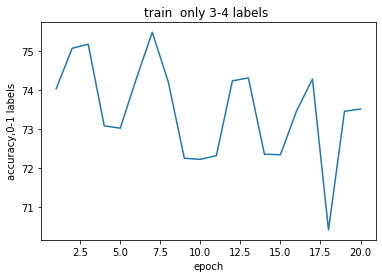

In [10]:
ans = np.zeros(20)
for i in range(10):
  ans = ans + np.array(answers[i])/10
x = np.arange(1,21,1)
plt.plot(x,ans)
plt.title('train  only 3-4 labels ')
plt.xlabel('epoch')
plt.ylabel('accuracy,0-1 labels')
plt.show

In [12]:
net = MnistNet()
optimiser = torch.optim.Adam(net.parameters())
answers = []
for i in range(10):
  net1, acc = train(net,optimiser,2)
  ans = forget(net1,optimiser,20,train_loader34,test_loader)
  answers.append(ans)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.90543365478516
Epoch 1, Accuracy 99.858154296875


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 63.87706756591797
Epoch 1, Accuracy 62.50590896606445
Epoch 2, Accuracy 55.74468231201172
Epoch 3, Accuracy 69.07801055908203
Epoch 4, Accuracy 68.55792236328125
Epoch 5, Accuracy 78.5342788696289
Epoch 6, Accuracy 79.47990417480469
Epoch 7, Accuracy 66.43025970458984
Epoch 8, Accuracy 51.20567321777344
Epoch 9, Accuracy 65.86288452148438
Epoch 10, Accuracy 56.832149505615234
Epoch 11, Accuracy 59.95271682739258
Epoch 12, Accuracy 64.11347198486328
Epoch 13, Accuracy 66.14656829833984
Epoch 14, Accuracy 67.89598083496094
Epoch 15, Accuracy 77.77777862548828
Epoch 16, Accuracy 71.5366439819336
Epoch 17, Accuracy 68.84160614013672
Epoch 18, Accuracy 67.56501007080078
Epoch 19, Accuracy 71.3947982788086


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.81087493896484
Epoch 1, Accuracy 99.858154296875


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 82.50591278076172
Epoch 1, Accuracy 81.08747100830078
Epoch 2, Accuracy 84.39716339111328
Epoch 3, Accuracy 89.12529754638672
Epoch 4, Accuracy 81.93853759765625
Epoch 5, Accuracy 78.72340393066406
Epoch 6, Accuracy 79.57447052001953
Epoch 7, Accuracy 75.55555725097656
Epoch 8, Accuracy 78.95980834960938
Epoch 9, Accuracy 74.42080688476562
Epoch 10, Accuracy 73.80614471435547
Epoch 11, Accuracy 88.55792236328125
Epoch 12, Accuracy 83.87706756591797
Epoch 13, Accuracy 76.35933685302734
Epoch 14, Accuracy 79.52718353271484
Epoch 15, Accuracy 79.00709533691406
Epoch 16, Accuracy 80.52009582519531
Epoch 17, Accuracy 70.73285675048828
Epoch 18, Accuracy 68.03782653808594
Epoch 19, Accuracy 81.37115478515625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.62174987792969
Epoch 1, Accuracy 99.90543365478516


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 78.43971252441406
Epoch 1, Accuracy 86.19385528564453
Epoch 2, Accuracy 81.22931671142578
Epoch 3, Accuracy 81.37115478515625
Epoch 4, Accuracy 81.7494125366211
Epoch 5, Accuracy 76.9739990234375
Epoch 6, Accuracy 87.18675994873047
Epoch 7, Accuracy 81.1820297241211
Epoch 8, Accuracy 80.80377960205078
Epoch 9, Accuracy 85.4373550415039
Epoch 10, Accuracy 78.1560287475586
Epoch 11, Accuracy 82.1276626586914
Epoch 12, Accuracy 77.35224914550781
Epoch 13, Accuracy 83.5933837890625
Epoch 14, Accuracy 86.19385528564453
Epoch 15, Accuracy 86.57210540771484
Epoch 16, Accuracy 78.0141830444336
Epoch 17, Accuracy 77.16312408447266
Epoch 18, Accuracy 74.08983612060547
Epoch 19, Accuracy 81.41844177246094


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.76359558105469
Epoch 1, Accuracy 99.71630859375


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 79.19622039794922
Epoch 1, Accuracy 77.06855773925781
Epoch 2, Accuracy 80.04727935791016
Epoch 3, Accuracy 75.65011596679688
Epoch 4, Accuracy 69.07801055908203
Epoch 5, Accuracy 76.21749114990234
Epoch 6, Accuracy 78.58155822753906
Epoch 7, Accuracy 77.73049926757812
Epoch 8, Accuracy 73.00236511230469
Epoch 9, Accuracy 74.13711547851562
Epoch 10, Accuracy 78.72340393066406
Epoch 11, Accuracy 76.02836608886719
Epoch 12, Accuracy 83.92434692382812
Epoch 13, Accuracy 84.86997985839844
Epoch 14, Accuracy 83.73522186279297
Epoch 15, Accuracy 82.41134643554688
Epoch 16, Accuracy 79.05437469482422
Epoch 17, Accuracy 81.51300048828125
Epoch 18, Accuracy 67.18675994873047
Epoch 19, Accuracy 71.3947982788086


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.858154296875
Epoch 1, Accuracy 99.90543365478516


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 80.52009582519531
Epoch 1, Accuracy 76.21749114990234
Epoch 2, Accuracy 85.86288452148438
Epoch 3, Accuracy 80.94562530517578
Epoch 4, Accuracy 79.33805847167969
Epoch 5, Accuracy 82.36406707763672
Epoch 6, Accuracy 83.35697174072266
Epoch 7, Accuracy 81.1820297241211
Epoch 8, Accuracy 83.49881744384766
Epoch 9, Accuracy 83.5933837890625
Epoch 10, Accuracy 83.1678466796875
Epoch 11, Accuracy 71.96217346191406
Epoch 12, Accuracy 82.69503784179688
Epoch 13, Accuracy 70.35460662841797
Epoch 14, Accuracy 62.4586296081543
Epoch 15, Accuracy 77.49408721923828
Epoch 16, Accuracy 77.82505798339844
Epoch 17, Accuracy 70.35460662841797
Epoch 18, Accuracy 83.0260009765625
Epoch 19, Accuracy 76.31205749511719


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.57447052001953
Epoch 1, Accuracy 99.66902923583984


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 85.39006805419922
Epoch 1, Accuracy 89.50354766845703
Epoch 2, Accuracy 82.64775085449219
Epoch 3, Accuracy 86.95035552978516
Epoch 4, Accuracy 84.11347198486328
Epoch 5, Accuracy 83.82978820800781
Epoch 6, Accuracy 74.5626449584961
Epoch 7, Accuracy 68.98345184326172
Epoch 8, Accuracy 73.80614471435547
Epoch 9, Accuracy 70.87470245361328
Epoch 10, Accuracy 70.49645233154297
Epoch 11, Accuracy 71.34751892089844
Epoch 12, Accuracy 73.5224609375
Epoch 13, Accuracy 75.03546142578125
Epoch 14, Accuracy 79.43262481689453
Epoch 15, Accuracy 72.62411499023438
Epoch 16, Accuracy 69.31442260742188
Epoch 17, Accuracy 74.75177001953125
Epoch 18, Accuracy 75.79196166992188
Epoch 19, Accuracy 70.49645233154297


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.71630859375
Epoch 1, Accuracy 99.71630859375


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 76.12293243408203
Epoch 1, Accuracy 80.70922088623047
Epoch 2, Accuracy 72.95508575439453
Epoch 3, Accuracy 71.72576904296875
Epoch 4, Accuracy 80.80377960205078
Epoch 5, Accuracy 76.9739990234375
Epoch 6, Accuracy 81.56028747558594
Epoch 7, Accuracy 78.8179702758789
Epoch 8, Accuracy 72.10401916503906
Epoch 9, Accuracy 68.98345184326172
Epoch 10, Accuracy 72.95508575439453
Epoch 11, Accuracy 76.87943267822266
Epoch 12, Accuracy 73.94799041748047
Epoch 13, Accuracy 78.48699951171875
Epoch 14, Accuracy 71.58392333984375
Epoch 15, Accuracy 69.21985626220703
Epoch 16, Accuracy 73.23876953125
Epoch 17, Accuracy 67.47045135498047
Epoch 18, Accuracy 77.49408721923828
Epoch 19, Accuracy 77.02127838134766


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.76359558105469
Epoch 1, Accuracy 99.81087493896484


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 88.27423095703125
Epoch 1, Accuracy 80.18912506103516
Epoch 2, Accuracy 92.24586486816406
Epoch 3, Accuracy 87.47045135498047
Epoch 4, Accuracy 87.65957641601562
Epoch 5, Accuracy 85.95744323730469
Epoch 6, Accuracy 75.98108673095703
Epoch 7, Accuracy 82.78959655761719
Epoch 8, Accuracy 79.38534545898438
Epoch 9, Accuracy 75.17730712890625
Epoch 10, Accuracy 70.54373168945312
Epoch 11, Accuracy 78.06146240234375
Epoch 12, Accuracy 76.26477813720703
Epoch 13, Accuracy 74.9408950805664
Epoch 14, Accuracy 80.66194152832031
Epoch 15, Accuracy 73.94799041748047
Epoch 16, Accuracy 87.75413513183594
Epoch 17, Accuracy 80.66194152832031
Epoch 18, Accuracy 81.79669189453125
Epoch 19, Accuracy 72.24586486816406


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.71630859375
Epoch 1, Accuracy 99.66902923583984


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 95.88652801513672
Epoch 1, Accuracy 93.80614471435547
Epoch 2, Accuracy 88.98345184326172
Epoch 3, Accuracy 84.7754135131836
Epoch 4, Accuracy 90.2127685546875
Epoch 5, Accuracy 91.01654815673828
Epoch 6, Accuracy 84.53900909423828
Epoch 7, Accuracy 84.68085479736328
Epoch 8, Accuracy 74.46808624267578
Epoch 9, Accuracy 85.76831817626953
Epoch 10, Accuracy 84.9172592163086
Epoch 11, Accuracy 83.26241302490234
Epoch 12, Accuracy 78.95980834960938
Epoch 13, Accuracy 82.17494201660156
Epoch 14, Accuracy 78.0141830444336
Epoch 15, Accuracy 79.19622039794922
Epoch 16, Accuracy 77.77777862548828
Epoch 17, Accuracy 78.48699951171875
Epoch 18, Accuracy 78.6761245727539
Epoch 19, Accuracy 86.24113464355469


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Accuracy 99.66902923583984
Epoch 1, Accuracy 99.76359558105469


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Accuracy 92.34042358398438
Epoch 1, Accuracy 91.86761474609375
Epoch 2, Accuracy 92.71867370605469
Epoch 3, Accuracy 89.97635650634766
Epoch 4, Accuracy 89.03073120117188
Epoch 5, Accuracy 86.903076171875
Epoch 6, Accuracy 84.96453857421875
Epoch 7, Accuracy 85.1536636352539
Epoch 8, Accuracy 83.82978820800781
Epoch 9, Accuracy 83.78250885009766
Epoch 10, Accuracy 85.57919311523438
Epoch 11, Accuracy 85.53191375732422
Epoch 12, Accuracy 85.34278869628906
Epoch 13, Accuracy 79.33805847167969
Epoch 14, Accuracy 80.80377960205078
Epoch 15, Accuracy 88.17967224121094
Epoch 16, Accuracy 88.13238525390625
Epoch 17, Accuracy 86.71395111083984
Epoch 18, Accuracy 83.07328796386719
Epoch 19, Accuracy 83.21513366699219


<function matplotlib.pyplot.show>

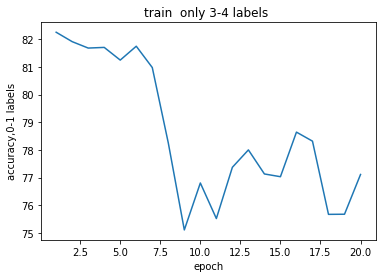

In [13]:
ans = np.zeros(20)
for i in range(10):
  ans = ans + np.array(answers[i])/10
x = np.arange(1,21,1)
plt.plot(x,ans)
plt.title('train  only 3-4 labels ')
plt.xlabel('epoch')
plt.ylabel('accuracy,0-1 labels')
plt.show

# Пояснение к результатам
Как видно из предыдущего кода, я провел три примерно одинаковых эксперимента.
1)Элементы 2-3 вставляются в датасет для обучения. Тогда видимого эффекта не происходит.
2)Обучающая выборка состоит из элементов 2-3, размер батча 8
3)Обучающая выборка состоит из элементов 2-3, размер батча 16
Понятно, что итоги для 2) и 3) должны примерно совпадать, но мы видим, что переход от 90+ к 75(значение можно проинтерпретировать,среднее из порядка 50% для 0-1 и 99% для 2-3) в обоих случаях очень быстрый. Также можно заметить, что результаты варьируются при различных запусках довольно сильно: при усреднении по 10 запускам происходят большие колебания.